# _Moneyballing Fantasy Premier League Football_
# Network Analysis

We can use network analysis to work out how inter-dependent different players are on each other. We can do this by looking at how players are 'assisting' each other's shots - note, an 'assist' is the pass from one player to another, from which the receiving player immediately shoots. It can be the case that a shot has no assisting player.

Assists are a big part of FPL (notwithstanding the FPL podcast 'Who Got The Assist'). Players get 3 points for every assist - for strikers this is 75% as many points as for scoring the goal itself.

### Bringing in the required libraries...

In [1]:
#Standard data manipulations
import pandas as pd
import numpy as np

#SQL
import sqlite3
#Including custom functions, stored elsewhere in the repo
from PythonFunctions.sqlfunctions import *

#NetworkX
import networkx as nx

#Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#Import custom visuals settings
from PythonFunctions.cb91visuals import *

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

Let's bring in some of the data we have in the SQL database.

In [2]:
conn = sqlite3.connect('Data/fpl.db')
c = conn.cursor()
df_players = sql('SELECT * FROM PlayersBasic', c)
df_teams = sql('SELECT * FROM TeamsBasic', c).head(20)
df_teams['TeamColor'] = df_teams['ShortName'].map(lambda x: team_colors[x])
df = sql('SELECT * FROM ShotsDetail', c)
df.drop(3501, inplace=True)
df.head()

,TableIndex,MatchID,GameWeek,Player,ForTeam,AgainstTeam,RelativeStrength,Time,ShotOutcome,AssistedBy,ShotType,ShotPosition,ShotSide,Close
ShotsDetailID,,,,,,,,,,,,,,
1,0,46605,1,Teemu Pukki,Norwich City,Liverpool,-3,64,Goal,Emiliano Buendia,right footed shot,the box,the centre,close
2,1,46605,1,Divock Origi,Liverpool,Norwich City,3,42,Goal,Trent Alexander-Arnold,header,the box,the centre,close
3,2,46605,1,Virgil van Dijk,Liverpool,Norwich City,3,28,Goal,Mohamed Salah,header,the box,the centre,close
4,3,46605,1,Mohamed Salah,Liverpool,Norwich City,3,19,Goal,Roberto Firmino,left footed shot,the box,the right,close
5,4,46605,1,Moritz Leitner,Norwich City,Liverpool,-3,62,Woodwork,Todd Cantwell,right footed shot,the box,the right,close


We can see that a quarter of shots are assisted by no player in particular:

In [3]:
round(len(df.loc[df['AssistedBy']=='N/A']) / len(df),2)

0.26

Let's consider the players who have assisted the most shots in the season so far...

In [4]:
df.loc[df['AssistedBy']!='N/A'].groupby(['AssistedBy','ForTeam']).count().sort_values(
    'Player', ascending=False)[['Player']].head(10).reset_index()

,AssistedBy,ForTeam,Player
0,James Maddison,Leicester City,124
1,Joao Moutinho,Wolverhampton Wanderers,117
2,Kevin De Bruyne,Manchester City,115
3,Emiliano Buendia,Norwich City,98
4,Pascal Groß,Brighton and Hove Albion,94
5,Trent Alexander-Arnold,Liverpool,92
6,Jack Grealish,Aston Villa,92
7,Lucas Digne,Everton,85
8,Raul Jimenez,Wolverhampton Wanderers,81
9,James Ward-Prowse,Southampton,78


What about players that have had the most 'shot involvement', i.e. the sum of shots taken and shots assisted?

In [5]:
df_players.loc[df_players['CommentName']=='Bruno Miguel Fernandes', 'CommentName'] = 'Bruno Fernandes'

In [6]:
#Create an 'involvement table' with each player
df_inv = df_players[['CommentName','Team']].set_index('CommentName')

df_inv['TotalShots'] = df.groupby('Player').count()['TableIndex']
df_inv['TotalCreated'] = df.groupby('AssistedBy').count()['TableIndex']

df_goals = df.loc[df['ShotOutcome']=='Goal']
df_inv['Goals'] = df_goals.groupby('Player').count()['TableIndex']
df_inv['Assists'] = df_goals.groupby('AssistedBy').count()['TableIndex']

df_inv.fillna(0, inplace=True)
df_inv['ShotInvolvement'] = df_inv['TotalShots'] + df_inv['TotalCreated']
df_inv['GoalInvolvement'] = df_inv['Goals'] + df_inv['Assists']

Let's look at the players who've been involved in most shots and goals.

In [7]:
df_inv.sort_values('ShotInvolvement', ascending=False).head(10)[['ShotInvolvement']]

,ShotInvolvement
CommentName,
Raul Jimenez,259.0
James Maddison,233.0
Kevin De Bruyne,208.0
Mohamed Salah,185.0
Neal Maupay,161.0
Jack Grealish,160.0
Roberto Firmino,156.0
Danny Ings,153.0
Joao Moutinho,151.0


In [8]:
df_inv.sort_values('GoalInvolvement', ascending=False).head(10)[['GoalInvolvement']]

,GoalInvolvement
CommentName,
Jamie Vardy,39.0
Raul Jimenez,34.0
Danny Ings,30.0
Kevin De Bruyne,30.0
Sergio Aguero,26.0
Sadio Mane,26.0
Mohamed Salah,24.0
Pierre-Emerick Aubameyang,22.0
Son Heung-Min,22.0


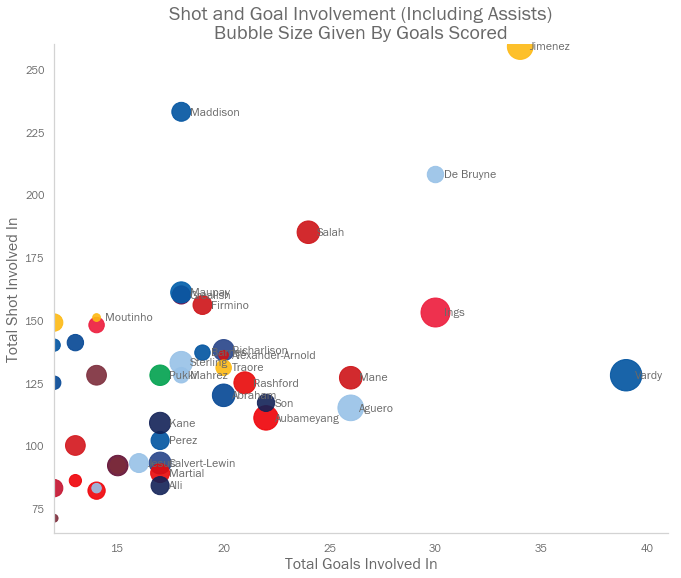

In [9]:
plt.rcParams["figure.facecolor"] = 'white'
plt.figure(figsize=(11,9))

df_temp = df_inv.loc[df_inv['ShotInvolvement']>0]

Y=df_temp['ShotInvolvement']
X=df_temp['GoalInvolvement']
c=df_temp['Team'].map(
    lambda x: df_teams.loc[df_teams['CommentName']==x,'TeamColor'].item())
s=df_temp['Goals']*30
L=list(df_temp.index)

plt.scatter(X,Y,s=s,c=c,alpha=0.9)
plt.xlim(12,)
plt.ylim(65,260)

for i in L:
    try:
        x_text = X[i]
        y_text = Y[i]
        if (x_text>=16) or (y_text>150):
            name = df_players.loc[df_players['CommentName']==i,'WebName'].item()
            plt.text(x_text+0.4, y_text, name,
                     fontsize=12, color='dimgrey', ha='left', va='center')
    except:
        pass

plt.title('Shot and Goal Involvement (Including Assists)\nBubble Size Given By Goals Scored')
plt.xlabel('Total Goals Involved In')
plt.ylabel('Total Shot Involved In');

### Effective Partnerships

For now, let's consider total shots taken. Let's group by players, and who assisted them.

In [10]:
df_shots = df.groupby(['Player','AssistedBy','ForTeam']).count()[['TableIndex']].reset_index()
df_shots.columns = ['Player','AssistedBy','ForTeam','ShotsAssisted']
df_shots.head()

,Player,AssistedBy,ForTeam,ShotsAssisted
0,Aaron Connolly,Adam Webster,Brighton and Hove Albion,2
1,Aaron Connolly,Alireza Jahanbakhsh,Brighton and Hove Albion,2
2,Aaron Connolly,Bernardo,Brighton and Hove Albion,2
3,Aaron Connolly,Dale Stephens,Brighton and Hove Albion,2
4,Aaron Connolly,Dan Burn,Brighton and Hove Albion,4


We can look at the shooting players who've been most dependent on one individual...

In [11]:
df_shots.loc[df_shots['AssistedBy']!='N/A'].sort_values(
    'ShotsAssisted', ascending = False).head(10)

,Player,AssistedBy,ForTeam,ShotsAssisted
2203,Raul Jimenez,Adama Traore,Wolverhampton Wanderers,34
2206,Raul Jimenez,Joao Moutinho,Wolverhampton Wanderers,34
2570,Teemu Pukki,Emiliano Buendia,Norwich City,33
2291,Roberto Firmino,Trent Alexander-Arnold,Liverpool,28
2247,Richarlison,Lucas Digne,Everton,24
2445,Sergio Aguero,Kevin De Bruyne,Manchester City,23
732,Diogo Jota,Raul Jimenez,Wolverhampton Wanderers,22
1896,Mohamed Salah,Sadio Mane,Liverpool,22
1445,Jonny Evans,James Maddison,Leicester City,21
2310,Romain Saiss,Joao Moutinho,Wolverhampton Wanderers,21


And indeed the players who've been best at 'going it alone'.

In [12]:
df_shots.loc[df_shots['AssistedBy']=='N/A'].sort_values(
    'ShotsAssisted', ascending = False).head(10)

,Player,AssistedBy,ForTeam,ShotsAssisted
1237,James Ward-Prowse,N/A,Southampton,48
1065,Harry Wilson,N/A,Bournemouth,39
617,Danny Ings,N/A,Southampton,39
2210,Raul Jimenez,N/A,Wolverhampton Wanderers,39
730,Diogo Jota,N/A,Wolverhampton Wanderers,36
1203,James Maddison,N/A,Leicester City,35
1699,Marcus Rashford,N/A,Manchester United,35
2333,Ruben Neves,N/A,Wolverhampton Wanderers,33
2180,Pierre-Emile Højbjerg,N/A,Southampton,32
1893,Mohamed Salah,N/A,Liverpool,31


We can have a look at the most effective partnerships (i.e. how many shots have pairs of players created for each other in total).

In [13]:
keys = []
values = []
teams = []
for row in df_shots.loc[df_shots['AssistedBy']!='N/A'].itertuples():
    key = ', '.join(sorted([row.Player, row.AssistedBy]))
    value = row.ShotsAssisted
    team = row.ForTeam
    keys.append(key)
    values.append(value)
    teams.append(team)
df_pairs = pd.DataFrame({'Pair':keys, 'ShotsAssisted':values, 'Team':teams})
df_pairs = df_pairs.groupby(['Pair','Team']).sum().sort_values('ShotsAssisted', ascending=False)
df_pairs.head(10)

,,ShotsAssisted
Pair,Team,
"Adama Traore, Raul Jimenez",Wolverhampton Wanderers,50
"Emiliano Buendia, Teemu Pukki",Norwich City,37
"Joao Moutinho, Raul Jimenez",Wolverhampton Wanderers,36
"Diogo Jota, Raul Jimenez",Wolverhampton Wanderers,35
"Roberto Firmino, Trent Alexander-Arnold",Liverpool,33
"Kevin De Bruyne, Riyad Mahrez",Manchester City,32
"Mohamed Salah, Roberto Firmino",Liverpool,31
"James Maddison, Youri Tielemans",Leicester City,31
"James Maddison, Jamie Vardy",Leicester City,31


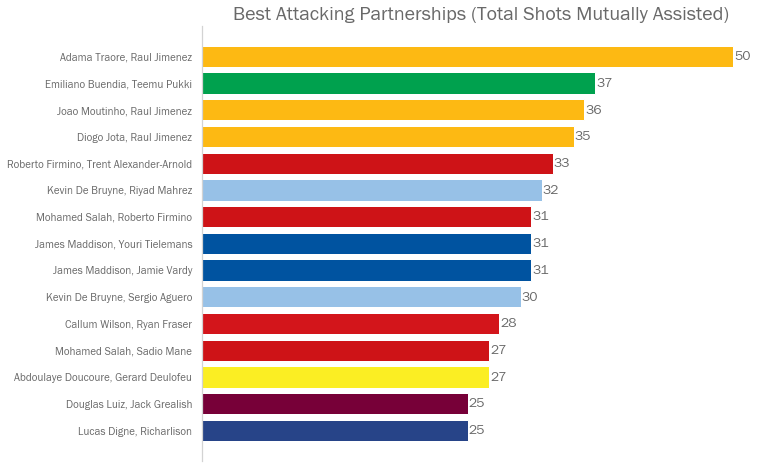

In [14]:
top_pairs = df_pairs.head(15)

X=top_pairs['ShotsAssisted'][::-1]
Y=[top_pairs.index[i][0] for i in range(15)][::-1]
T=[top_pairs.index[i][1] for i in range(15)][::-1]
C=[df_teams.loc[df_teams['CommentName']==i,'TeamColor'].item() for i in T]

plt.rcParams["figure.facecolor"] = 'white'
plt.figure(figsize=(10,8))

plt.barh(Y,X,color=C)
plt.xticks([])
sns.despine(bottom=True)

plt.title('Best Attacking Partnerships (Total Shots Mutually Assisted)')

for i, v in enumerate(X):
    plt.text(v + 0.1, i, str(round(v,2)), va='center', fontsize=14);

In [15]:
df_pairs.reset_index(inplace=True)
df_pairs['Player1'] = df_pairs['Pair'].map(lambda x: x.split(', ')[0])
df_pairs['Player2'] = df_pairs['Pair'].map(lambda x: x.split(', ')[1])

## Analysing Goal Threat

As we've seen in previous workbooks, not all shots are created equal. The data that we see for goals is likely to be different than that for overall shots. Let's investigate this in more detail.

Which player has assisted the most goals?

In [16]:
df.loc[(df['AssistedBy']!='N/A')&(df['ShotOutcome']=='Goal')].groupby(
    ['AssistedBy','ForTeam']).count().sort_values(
    'Player', ascending=False)[['Player']].head(12).reset_index()

,AssistedBy,ForTeam,Player
0,Kevin De Bruyne,Manchester City,21
1,Trent Alexander-Arnold,Liverpool,17
2,Son Heung-Min,Tottenham Hotspur,12
3,Joao Moutinho,Wolverhampton Wanderers,12
4,Adama Traore,Wolverhampton Wanderers,12
5,Raul Jimenez,Wolverhampton Wanderers,12
6,David Silva,Manchester City,11
7,Harvey Barnes,Leicester City,11
8,Pablo Fornals,West Ham United,10
9,Riyad Mahrez,Manchester City,10


In [17]:
df_goals = df.loc[df['ShotOutcome']=='Goal'].groupby(
    ['Player','AssistedBy','ForTeam']).count()[['TableIndex']].reset_index()
df_goals.columns = ['Player','AssistedBy','ForTeam','GoalsAssisted']
df_goals.head()

,Player,AssistedBy,ForTeam,GoalsAssisted
0,Aaron Connolly,Lewis Dunk,Brighton and Hove Albion,2
1,Aaron Connolly,N/A,Brighton and Hove Albion,2
2,Aaron Cresswell,Felipe Anderson,West Ham United,1
3,Aaron Cresswell,N/A,West Ham United,2
4,Aaron Cresswell,Pablo Fornals,West Ham United,2


Which teammates have players been most dependent on for their goals?

In [18]:
df_goals.loc[df_goals['AssistedBy']!='N/A'].sort_values(
    'GoalsAssisted', ascending = False).head(10)

,Player,AssistedBy,ForTeam,GoalsAssisted
429,Raul Jimenez,Adama Traore,Wolverhampton Wanderers,9
492,Sergio Aguero,Kevin De Bruyne,Manchester City,8
15,Adama Traore,Raul Jimenez,Wolverhampton Wanderers,6
234,Jamie Vardy,Harvey Barnes,Leicester City,6
549,Virgil van Dijk,Trent Alexander-Arnold,Liverpool,5
524,Teemu Pukki,Emiliano Buendia,Norwich City,5
490,Sergio Aguero,David Silva,Manchester City,5
437,Richarlison,Djibril Sidibe,Everton,5
95,Chris Wood,Dwight McNeil,Burnley,5
426,Raheem Sterling,Kevin De Bruyne,Manchester City,5


And which players have had the most impactful goalscoring partnerships?

In [19]:
keys = []
values = []
for row in df_goals.loc[df_goals['AssistedBy']!='N/A'].itertuples():
    key = ', '.join(sorted([row.Player, row.AssistedBy]))
    value = row.GoalsAssisted
    keys.append(key)
    values.append(value)
df_goalpairs = pd.DataFrame({'Pair':keys, 'GoalsAssisted':values})
df_goalpairs = df_goalpairs.groupby('Pair').sum().sort_values(
    'GoalsAssisted', ascending=False)
df_goalpairs.head(10)

,GoalsAssisted
Pair,
"Adama Traore, Raul Jimenez",15
"Kevin De Bruyne, Sergio Aguero",8
"Nicolas Pepe, Pierre-Emerick Aubameyang",6
"Harvey Barnes, Jamie Vardy",6
"Trent Alexander-Arnold, Virgil van Dijk",5
"Douglas Luiz, Jack Grealish",5
"Anthony Martial, Marcus Rashford",5
"Kevin De Bruyne, Raheem Sterling",5
"Mohamed Salah, Roberto Firmino",5


## Team Share of Shots / Goals

Let's think about the share of shots and goals that a player has for their team.

In [20]:
unique_players = df

In [21]:
#Declare the share dataframe
df_share = df_players[['CommentName', 'Team']].set_index('CommentName')
#Calculate total shots
df_share['Shots'] = df.groupby('Player').count()['TableIndex']
#Calculate total created
df_share['Created'] = df.groupby('AssistedBy').count()['TableIndex']
#Calculate goals
df_share['Goals'] = df.loc[df['ShotOutcome']=='Goal'].groupby('Player').count()['TableIndex']
#Calcualte assists
df_share['Assists'] = df.loc[df['ShotOutcome']=='Goal'].groupby('AssistedBy').count()['TableIndex']

#Fill in NAs
df_share.fillna(0, inplace=True)

#Calculate total shot/goal involvement
df_share['ShotInv'] = df_share['Shots'] + df_share['Created']
df_share['GoalInv'] = df_share['Goals'] + df_share['Assists']

In [22]:
#Create shots and goals columns in the teams dataframe
team_shots = df.groupby('ForTeam').count()['TableIndex']
team_goals = df.loc[df['ShotOutcome']=='Goal'].groupby('ForTeam').count()['TableIndex']

df_share['TeamShots'] = df_share['Team'].map(lambda x: team_shots[x])
df_share['TeamGoals'] = df_share['Team'].map(lambda x: team_goals[x])

#Create shares of shots and goals
df_share['%Shots'] = df_share['Shots'] / df_share['TeamShots']
df_share['%Created'] = df_share['Created'] / df_share['TeamShots']
df_share['%ShotInv'] = df_share['ShotInv'] / df_share['TeamShots']

df_share['%Goals'] = df_share['Goals'] / df_share['TeamGoals']
df_share['%Assists'] = df_share['Assists'] / df_share['TeamGoals']
df_share['%GoalInv'] = df_share['GoalInv'] / df_share['TeamGoals']

In [23]:
df_share.head()

,Team,Shots,Created,Goals,Assists,ShotInv,GoalInv,TeamShots,TeamGoals,%Shots,%Created,%ShotInv,%Goals,%Assists,%GoalInv
CommentName,,,,,,,,,,,,,,,
Shkodran Mustafi,Arsenal,7.0,1.0,0.0,1.0,8.0,1.0,392,49,0.017857,0.002551,0.020408,0.000000,0.020408,0.020408
Hector Bellerin,Arsenal,5.0,2.0,1.0,0.0,7.0,1.0,392,49,0.012755,0.005102,0.017857,0.020408,0.000000,0.020408
Sead Kolasinac,Arsenal,4.0,10.0,0.0,3.0,14.0,3.0,392,49,0.010204,0.025510,0.035714,0.000000,0.061224,0.061224
Ainsley Maitland-Niles,Arsenal,3.0,9.0,0.0,2.0,12.0,2.0,392,49,0.007653,0.022959,0.030612,0.000000,0.040816,0.040816
Sokratis,Arsenal,10.0,2.0,2.0,0.0,12.0,2.0,392,49,0.025510,0.005102,0.030612,0.040816,0.000000,0.040816


Let's plot a scatter of this.

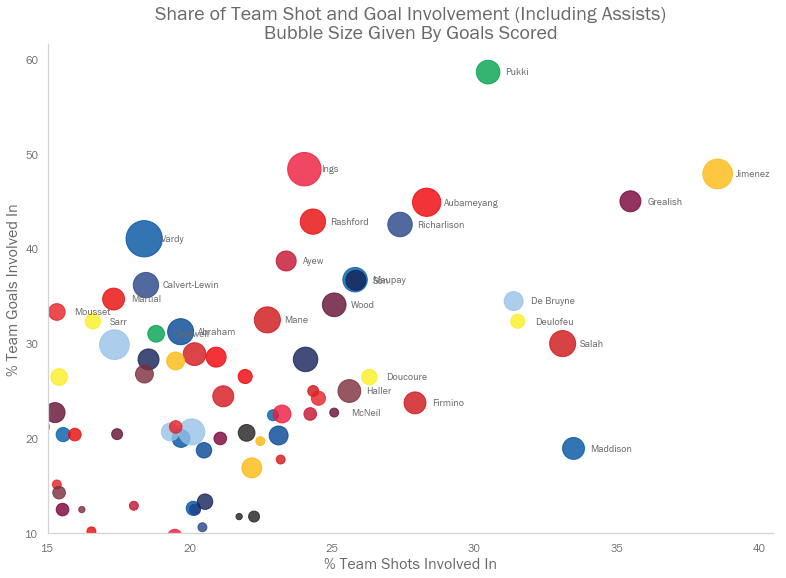

In [62]:
plt.rcParams["figure.facecolor"] = 'white'
plt.figure(figsize=(13,9))

X=df_share['%ShotInv']*100
Y=df_share['%GoalInv']*100
c=df_share['Team'].map(
    lambda x: df_teams.loc[df_teams['CommentName']==x,'TeamColor'].item())
s=df_share['Goals']*40
L=list(df_temp.index)

plt.scatter(X,Y,s=s,c=c,alpha=0.8)
plt.xlim(15)
plt.ylim(10)

for i in L:
    try:
        x_text = X[i]
        y_text = Y[i]
        s_text = s[i]
        if (s_text>0) and ((x_text>=25) or (y_text>31)):
            name = df_players.loc[df_players['CommentName']==i,'WebName'].item()
            plt.text(x_text+0.6, y_text, name,
                     fontsize=10, color='dimgrey', ha='left', va='center')
    except:
        pass

plt.title('Share of Team Shot and Goal Involvement (Including Assists)\nBubble Size Given By Goals Scored')
plt.xlabel('% Team Shots Involved In')
plt.ylabel('% Team Goals Involved In');

## Network Analysis

Why might we want to apply more technical network analysis?

Firstly, we can investigate the inter-connectedness of a team, giving us a sense of how the team plays. Secondly, we can identify the most 'connected' players within each team, giving us a sense of who the most instrumental players seem to be.

Let's firstly bring in a full dataframe of players in the game.

In [25]:
c = conn.cursor()
df_players = sql('SELECT * FROM PlayersBasic', c)
df_players.head()

,PlayerID,PlayerCode,FirstName,WebName,Team,Position,CommentName
PlayersBasicID,,,,,,,
1,1,69140,Shkodran,Mustafi,Arsenal,DEF,Shkodran Mustafi
2,2,98745,Hector,Bellerin,Arsenal,DEF,Hector Bellerin
3,3,111457,Sead,Kolasinac,Arsenal,DEF,Sead Kolasinac
4,4,154043,Ainsley,Maitland-Niles,Arsenal,DEF,Ainsley Maitland-Niles
5,5,39476,Sokratis,Sokratis,Arsenal,DEF,Sokratis


We can instantiate a graph for each team, and store in a dictionary. We'll add edges to these later.

In [26]:
unique_teams = list(df_players['Team'].unique())
networks = {}
for i in unique_teams:
    networks[i] = nx.Graph()
    players = list(df_players.loc[df_players['Team']==i, 'CommentName'])
    for player in players:
        networks[i].add_node(player)

Let's check that this worked...

In [27]:
networks['Watford'].nodes

NodeView(('Jose Holebas', 'Christian Kabasele', 'Adam Masina', 'Adrian Mariappa', 'Kiko Femenia', 'Craig Cathcart', 'Daryl Janmaat', 'Marc Navarro', 'Sebastian Prodl', 'Troy Deeney', 'Gerard Deulofeu', 'Andre Gray', 'Isaac Success', 'Ben Foster', 'Pontus Dahlberg', 'Abdoulaye Doucoure', 'Roberto Pereyra', 'Will Hughes', 'Tom Cleverley', 'Ken Sema', 'Etienne Capoue', 'Nathaniel Chalobah', 'Domingos Quina', 'Craig Dawson', 'Danny Welbeck', 'Heurelho Gomes', 'Ismaila Sarr', 'Dimitri Foulquier', 'Tom Dele-Bashiru', 'Joao Pedro', 'Ignacio Pussetto'))

Now we can add edges.

Recall our 'pairs' dataframe, looking at shots that players assisted for each other.

In [28]:
df_pairs.head()

,Pair,Team,ShotsAssisted,Player1,Player2
0,"Adama Traore, Raul Jimenez",Wolverhampton Wanderers,50,Adama Traore,Raul Jimenez
1,"Emiliano Buendia, Teemu Pukki",Norwich City,37,Emiliano Buendia,Teemu Pukki
2,"Joao Moutinho, Raul Jimenez",Wolverhampton Wanderers,36,Joao Moutinho,Raul Jimenez
3,"Diogo Jota, Raul Jimenez",Wolverhampton Wanderers,35,Diogo Jota,Raul Jimenez
4,"Roberto Firmino, Trent Alexander-Arnold",Liverpool,33,Roberto Firmino,Trent Alexander-Arnold


We can iterate through these rows and add the weights as edges...

In [29]:
for row in df_pairs.itertuples():
    #Get the team and partnership in question
    team = row.Team
    player1 = row.Player1
    player2 = row.Player2
    shots = row.ShotsAssisted
    
    #Find the appropriate graph and add the weight
    networks[team].add_edge(player1, player2, weight=shots)

We can see that this has worked!

In [30]:
len(networks['Watford'].edges())

89

We can visualise these networks using NetworkX's inbuilt methods.

In [31]:
def draw_network(team, size=(9,8), lw=2.5, seed=None, k=None, lc='black'):
    '''
    Takes a team name, and outputs a visualisation of how
    connected the players on the team have been through the season.
    '''
    
    if k==None:
        k=size[0]*0.4
    
    #Get the network and remove isolated nodes
    G = networks[team]
    G.remove_nodes_from(list(nx.isolates(G)))
    
    #Get the team color for the nodes
    ncolor = df_teams.loc[df_teams['CommentName']==team,
                             'TeamColor'].item()
    
    #Calculate the node sizes and the edge weights
    sizes = np.array([df_inv.loc[i,['ShotInvolvement']].iloc[0].item()
                  for i in G.nodes])*100
    weights = [(G[u][v]['weight']**1.5)*(lw/10) for u,v in G.edges()]
    
    #Draw the plot
    plt.figure(figsize=size)
    nx.draw(G,
            pos=nx.spring_layout(G, k=5.4),
            with_labels=True,
            node_size=sizes,
            node_color=ncolor,
            width=weights,
            font_weight="bold",
            font_color=lc,
            alpha=.9,
            edge_color="grey")
    title = f'{team} Player Interdependence'
    plt.title(title)

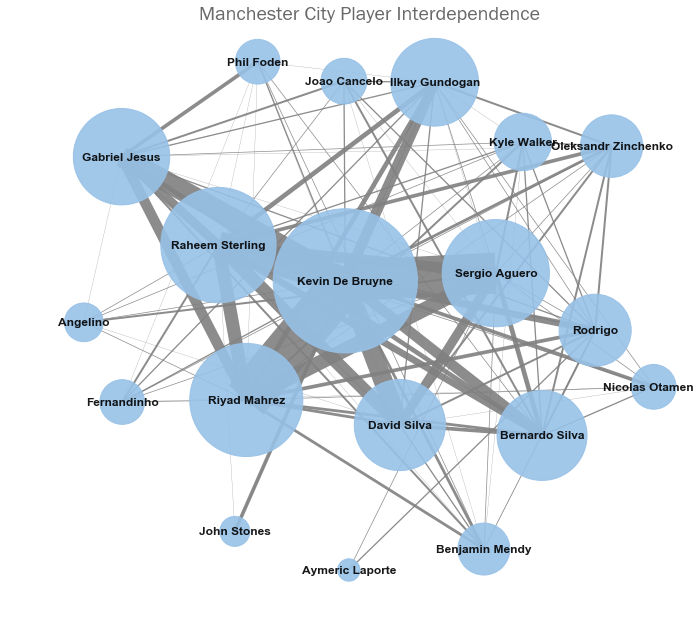

In [72]:
draw_network('Manchester City')

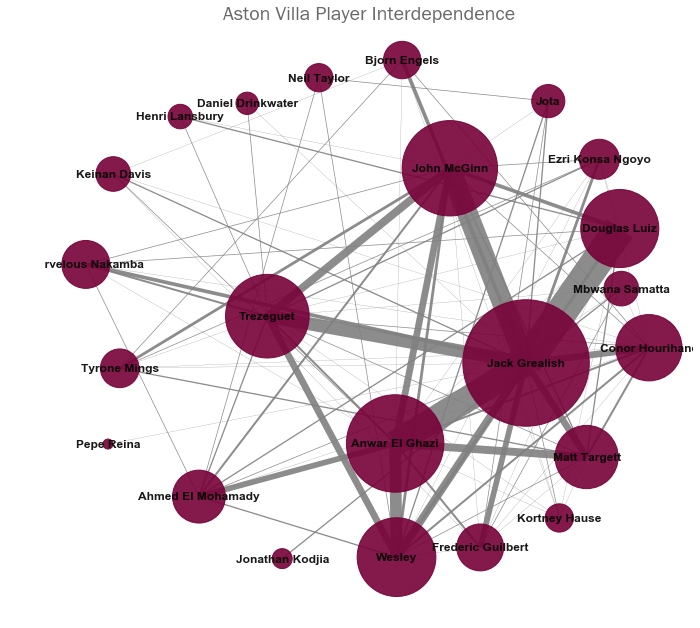

In [74]:
draw_network('Aston Villa')

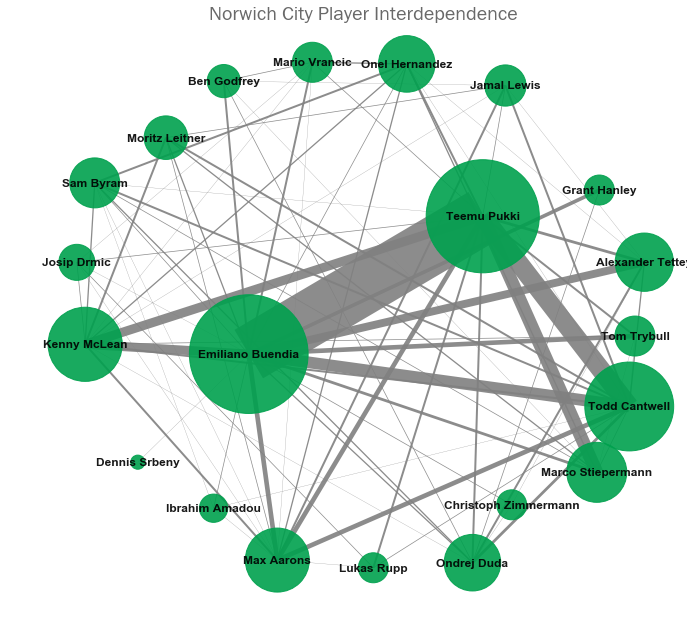

In [34]:
draw_network('Norwich City')

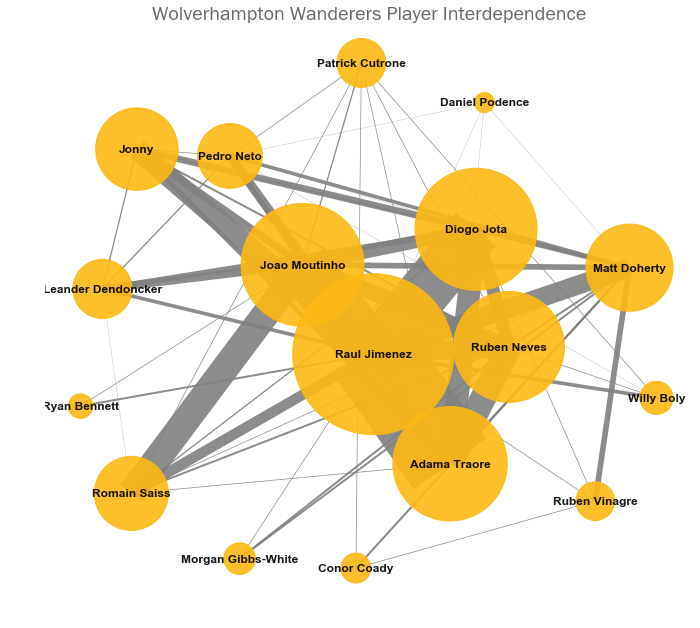

In [79]:
draw_network('Wolverhampton Wanderers')

### Player centrality

We can look at the different definitions of node centrality in turn to see the influence of different players, creating a dataframe out of these figures.

In [36]:
#Declare columns and create a blank dataframe
cols = ['Team','Degree','Closeness','Betweenness','Eigen']
df_centrality = pd.DataFrame(columns=cols)

#Iterate through the different teams' networks
for i in unique_teams:
    temp_G = networks[i]
    
    #For the team, create dictionaries of what we want
    team = {player:i for player in list(temp_G.nodes)}
    degree = dict(nx.degree(temp_G))
    closeness = {i:nx.closeness_centrality(temp_G, i)
                 for i in temp_G.nodes}
    betweenness = nx.betweenness_centrality(temp_G)
    eigen = nx.eigenvector_centrality(temp_G)
    
    #Create a dataframe
    df_temp = pd.DataFrame([team,degree,closeness,
                           betweenness,eigen]).T
    df_temp.columns = cols
    
    #Append it to our centrality dataframe
    df_centrality = pd.concat([df_centrality, df_temp])

In [37]:
df_centrality.sort_values('Eigen', ascending=False).head()

,Team,Degree,Closeness,Betweenness,Eigen
Joelinton,Newcastle United,21,0.598659,0.137453,0.376154
Wilfried Zaha,Crystal Palace,18,0.606061,0.0954078,0.373044
Emiliano Buendia,Norwich City,18,0.909091,0.311992,0.365249
Raul Jimenez,Wolverhampton Wanderers,14,0.888889,0.191282,0.354603
Nicolas Pepe,Arsenal,20,0.611111,0.0886544,0.350722


This is interesting, though right now none of these measures are considering the weight that we gave to each edge (i.e. none of the measures reflect the fact that some players link up more than others - all it's currently looking at is whether or not two players have linked up at least once). Of course, we want a player to have a higher 'interconnectedness' if they are frequently involved in goal attempts.

Betweenness does give us the ability to consider weights, however NetworkX uses Dijkstra's algorithm, which would punish large weights (the opposite of what we want). A potenital solution here is to create a second set of weights for each edge, which consider the 'reciprocals' of the weights.

In [38]:
#Iterate through the different teams' networks
for i in unique_teams:
    temp_G = networks[i]
    #For each edge...
    for u,v,d in temp_G.edges(data=True):
        #...if we have a weight value
        if 'weight' in d:
            #...which is positive
            if d['weight'] != 0:
                #calculate the reciprocal
                d['reciprocal'] = 1/d['weight']

Let's see if this has worked.

In [39]:
testnet = networks['Watford']
print('Weight:', testnet['Jose Holebas']['Ismaila Sarr']['weight'])
print('Reciprocal:', testnet['Jose Holebas']['Ismaila Sarr']['reciprocal'])

Weight: 4
Reciprocal: 0.25


Great - we can also see how adding these reciprocal weights will increase the betweenness for important players.

In [40]:
#declare two tests - one without weighting, and one with.
test1 = nx.betweenness_centrality(testnet)
test2 = nx.betweenness_centrality(testnet, weight='reciprocal')

#turn this into a datafrmae and sort by weighted.
testnet_df = pd.DataFrame([test1, test2]).T
testnet_df.columns = ['Unweighted','Weighted']
testnet_df.sort_values('Weighted', ascending=False).head(5)

,Unweighted,Weighted
Gerard Deulofeu,0.053357,0.315709
Abdoulaye Doucoure,0.062221,0.136398
Ismaila Sarr,0.042214,0.125287
Tom Cleverley,0.065959,0.085057
Troy Deeney,0.030714,0.073563


We can see that this weighted measure is more representitive of the players that were more frequently involved in shots.

In [41]:
df_pairs.loc[df_pairs['Team']=='Watford'].head(10)

,Pair,Team,ShotsAssisted,Player1,Player2
12,"Abdoulaye Doucoure, Gerard Deulofeu",Watford,27,Abdoulaye Doucoure,Gerard Deulofeu
47,"Gerard Deulofeu, Troy Deeney",Watford,17,Gerard Deulofeu,Troy Deeney
58,"Gerard Deulofeu, Ismaila Sarr",Watford,15,Gerard Deulofeu,Ismaila Sarr
92,"Abdoulaye Doucoure, Ismaila Sarr",Watford,13,Abdoulaye Doucoure,Ismaila Sarr
155,"Ismaila Sarr, Troy Deeney",Watford,10,Ismaila Sarr,Troy Deeney
157,"Andre Gray, Will Hughes",Watford,10,Andre Gray,Will Hughes
178,"Andre Gray, Gerard Deulofeu",Watford,9,Andre Gray,Gerard Deulofeu
197,"Abdoulaye Doucoure, Will Hughes",Watford,9,Abdoulaye Doucoure,Will Hughes
200,"Gerard Deulofeu, Tom Cleverley",Watford,9,Gerard Deulofeu,Tom Cleverley
205,"Gerard Deulofeu, Will Hughes",Watford,8,Gerard Deulofeu,Will Hughes


Let's calculate this measure across teams.

In [42]:
weighted_dict = {}

for i in unique_teams:
    temp_G = networks[i]
    
    #For the team, create a dictionary of weighted betweenness
    betweenness = nx.betweenness_centrality(temp_G, weight='reciprocal')
    #Put the values in the dictionary
    weighted_dict.update(betweenness)
    
#Create a dataframe with one column
df_temp = pd.DataFrame([weighted_dict]).T
df_temp.columns = ['WeightBetweenness']

#Append it to our centrality dataframe
df_centrality = pd.concat([df_centrality, df_temp], axis=1, join='inner')

In [43]:
df_centrality.sort_values('WeightBetweenness', ascending=False).head(20)

,Team,Degree,Closeness,Betweenness,Eigen,WeightBetweenness
Jack Grealish,Aston Villa,20,0.916667,0.310249,0.347733,0.896104
Raul Jimenez,Wolverhampton Wanderers,14,0.888889,0.191282,0.354603,0.708333
Kevin De Bruyne,Manchester City,17,0.947368,0.0706522,0.301657,0.666667
Emiliano Buendia,Norwich City,18,0.909091,0.311992,0.365249,0.636842
Teemu Pukki,Norwich City,14,0.769231,0.074881,0.336575,0.344737
James Maddison,Leicester City,17,0.621118,0.130097,0.340584,0.328042
Joao Moutinho,Wolverhampton Wanderers,11,0.761905,0.0644765,0.323422,0.325000
Gerard Deulofeu,Watford,15,0.537778,0.0533572,0.334421,0.315709
Todd Cantwell,Norwich City,14,0.769231,0.0794173,0.331401,0.286842
Richarlison,Everton,16,0.54697,0.0490896,0.334007,0.282759


In [44]:
df_inv = df_inv.join(df_centrality[['WeightBetweenness']])
df_inv = df_inv.join(df_share[['%ShotInv']])

In [45]:
df_inv

,Team,TotalShots,TotalCreated,Goals,Assists,ShotInvolvement,GoalInvolvement,WeightBetweenness,%ShotInv
Aaron Connolly,Brighton and Hove Albion,50.0,8.0,4.0,0.0,58.0,4.0,0.000000,0.092949
Aaron Cresswell,West Ham United,23.0,28.0,5.0,0.0,51.0,5.0,0.000000,0.102000
Aaron Lennon,Burnley,2.0,2.0,0.0,0.0,4.0,0.0,0.000000,0.010899
Aaron Mooy,Brighton and Hove Albion,43.0,45.0,2.0,2.0,88.0,4.0,0.052688,0.141026
Aaron Ramsdale,Bournemouth,0.0,2.0,0.0,2.0,2.0,2.0,0.000000,0.004032
Aaron Wan-Bissaka,Manchester United,7.0,23.0,0.0,2.0,30.0,2.0,0.049242,0.058366
Abdoulaye Doucoure,Watford,63.0,48.0,6.0,3.0,111.0,9.0,0.136398,0.263033
Adam Idah,Norwich City,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000
Adam Lallana,Liverpool,5.0,5.0,1.0,2.0,10.0,3.0,0.000000,0.017889
Adam Masina,Watford,7.0,10.0,1.0,0.0,17.0,1.0,0.000000,0.040284


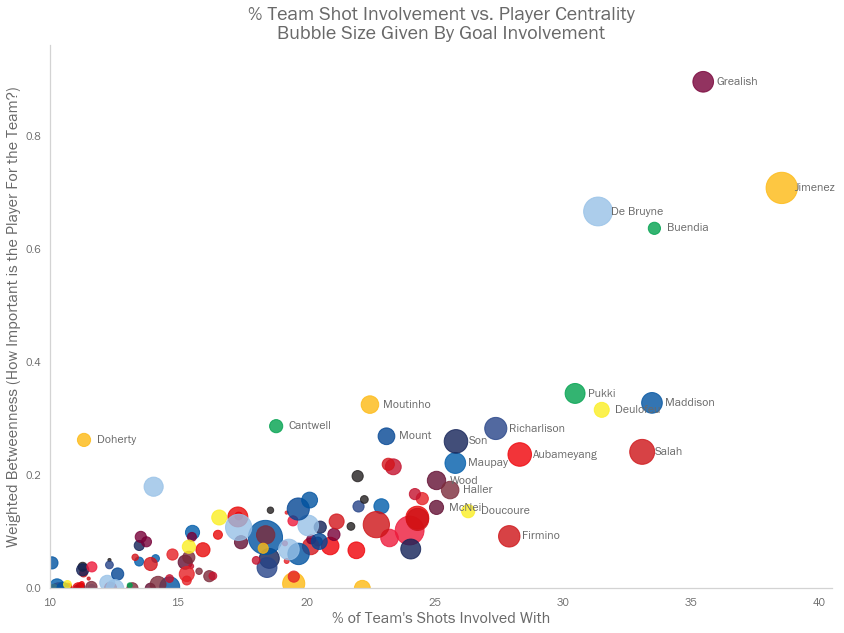

In [46]:
plt.rcParams["figure.facecolor"] = 'white'
plt.figure(figsize=(14,10))

X = df_inv['%ShotInv']*100
Y = df_inv['WeightBetweenness']
c = df_inv['Team'].map(
    lambda x: df_teams.loc[df_teams['CommentName']==x,'TeamColor'].item())
s = 10*df_inv['GoalInvolvement']**1.3
L = list(df_inv.index)

plt.scatter(X,Y,c=c,s=s,alpha=0.8)
plt.xlim(10)
plt.ylim(0)

for i in L:
    try:
        x_text = X[i]
        y_text = Y[i]
        if (x_text>=25) or (y_text>=0.22):
            name = df_players.loc[df_players['CommentName']==i,'WebName'].item()
            plt.text(x_text+0.5, y_text, name,
                     fontsize=12, color='dimgrey', ha='left', va='center')
    except:
        pass

plt.title('% Team Shot Involvement vs. Player Centrality\nBubble Size Given By Goal Involvement')
plt.xlabel("% of Team's Shots Involved With")
plt.ylabel('Weighted Betweenness (How Important is the Player For the Team?)');

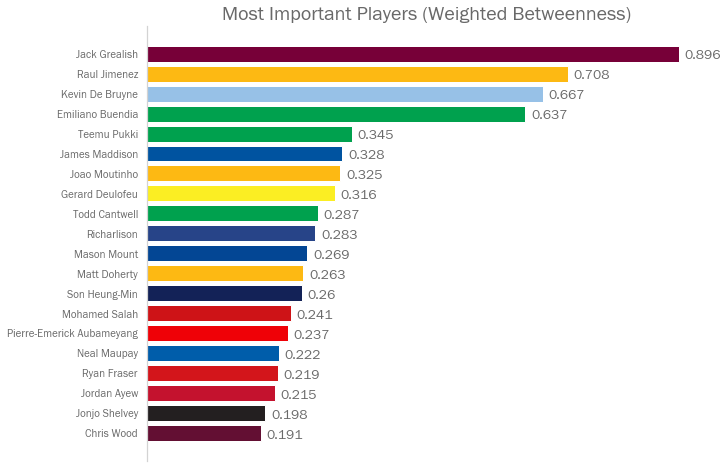

In [47]:
top_between = df_inv.sort_values('WeightBetweenness', ascending=False).head(20)

X=top_between['WeightBetweenness'][::-1]
Y=top_between.index[::-1]
T=top_between['Team'][::-1]
C=[df_teams.loc[df_teams['CommentName']==i,'TeamColor'].item() for i in T]

plt.rcParams["figure.facecolor"] = 'white'
plt.figure(figsize=(10,8))

plt.barh(Y,X,color=C)
plt.xticks([])
sns.despine(bottom=True)

plt.title('Most Important Players (Weighted Betweenness)')

for i, v in enumerate(X):
    plt.text(v + 0.01, i-0.1, str(round(v,3)), va='center', fontsize=14);

Who are the top 'talisman' players for each team?

In [48]:
df_talismen = df_inv.sort_values('WeightBetweenness', ascending=False)

talismen_players = pd.DataFrame()

for i in df_teams['CommentName'].unique():
    new_row = df_talismen.loc[df_talismen['Team']==i].head(1)
    talismen_players = pd.concat([talismen_players, new_row])

In [49]:
talismen_players.sort_values('WeightBetweenness', ascending=False, inplace=True)

team_and_player = [f"{df_teams.loc[df_teams['CommentName'] == talismen_players.iloc[i,0], 'ShortName'].item()} ({talismen_players.index[i]})"
 for i in range(20)]

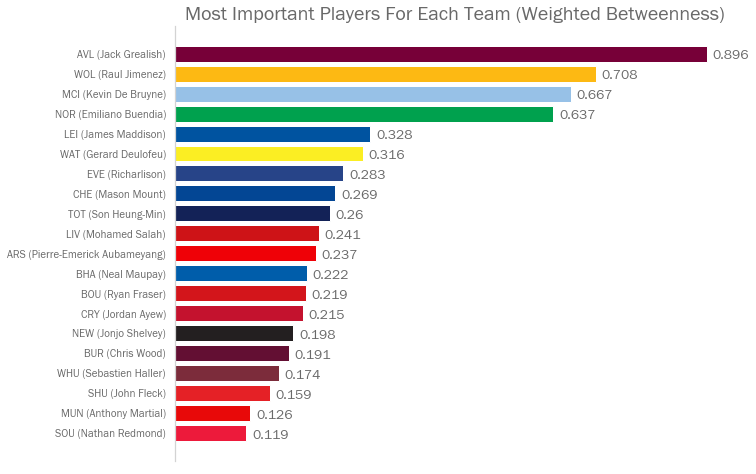

In [50]:
X=talismen_players['WeightBetweenness'][::-1]
Y=team_and_player[::-1]
T=talismen_players['Team'][::-1]
C=[df_teams.loc[df_teams['CommentName']==i,'TeamColor'].item() for i in T]

plt.rcParams["figure.facecolor"] = 'white'
plt.figure(figsize=(10,8))

plt.barh(Y,X,color=C)
plt.xticks([])
sns.despine(bottom=True)

plt.title('Most Important Players For Each Team (Weighted Betweenness)')

for i, v in enumerate(X):
    plt.text(v + 0.01, i-0.1, str(round(v,3)), va='center', fontsize=14);

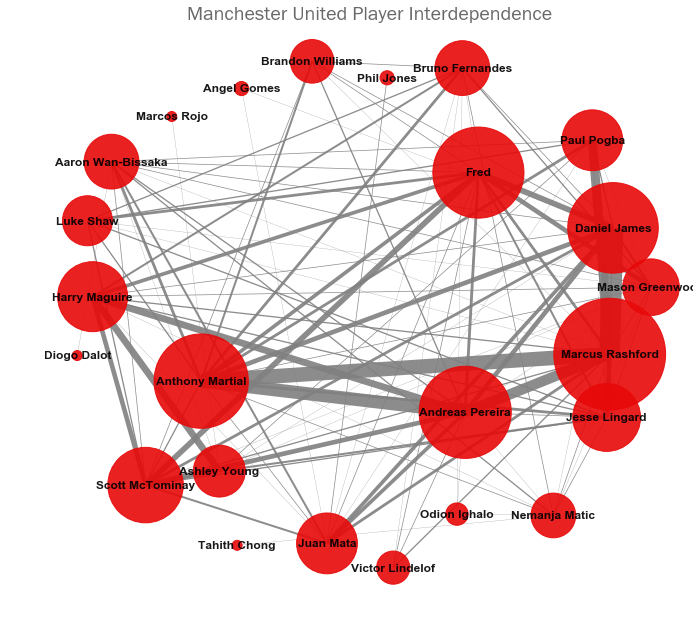

In [51]:
draw_network('Manchester United')

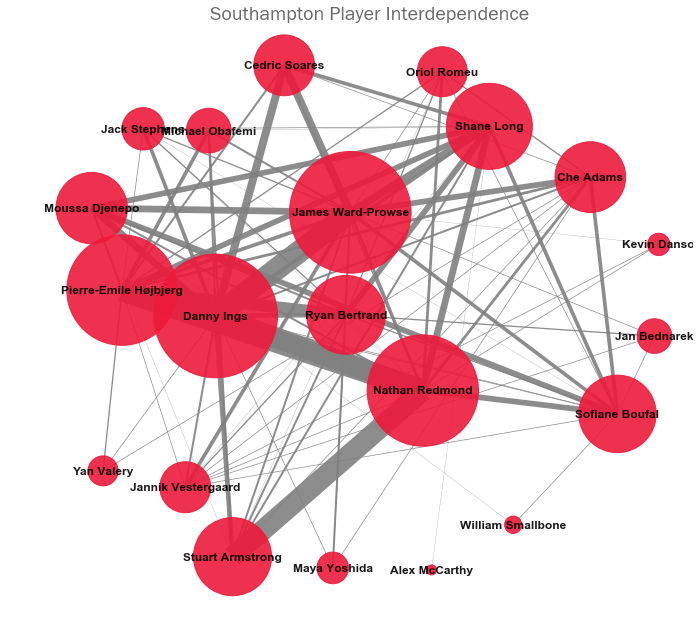

In [52]:
draw_network('Southampton')

Finally, what can we say about how well player centrality predicts points in fantasy premier league?

In [53]:
c = conn.cursor()
df_api = sql('SELECT * FROM PlayerAPIStats', c)

Calculate point per price...

In [54]:
df_players = pd.concat([df_players.set_index('PlayerID'),
           df_api.groupby('PlayerID').sum()[['Points']],
           df_api.groupby('PlayerID').mean()[['Price']]], axis=1).dropna()

df_players['PPP'] = df_players['Points'] / df_players['Price']

And add it to the df_inv

In [55]:
ppp = []
for i in df_inv.index:
    try:
        new_value = df_players.loc[df_players['CommentName']==i, 'PPP'].item()
        ppp.append(new_value)
    except:
        ppp.append(0)
    
df_inv['PPP']=ppp

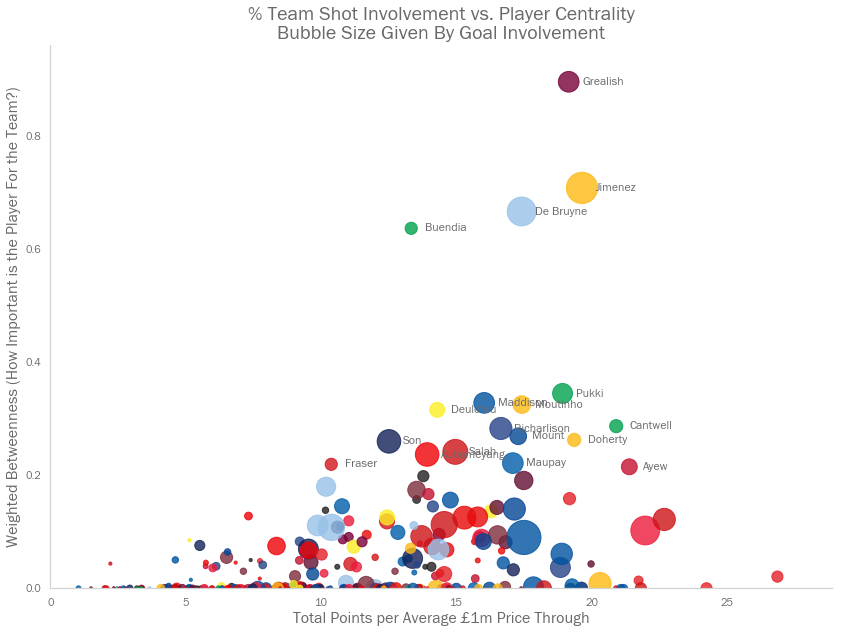

In [56]:
plt.rcParams["figure.facecolor"] = 'white'
plt.figure(figsize=(14,10))

X = df_inv['PPP']
Y = df_inv['WeightBetweenness']
c = df_inv['Team'].map(
    lambda x: df_teams.loc[df_teams['CommentName']==x,'TeamColor'].item())
s = 10*df_inv['GoalInvolvement']**1.3
L = list(df_inv.index)

plt.scatter(X,Y,c=c,s=s,alpha=0.8)
plt.xlim(0)
plt.ylim(0)

for i in L:
    try:
        x_text = X[i]
        y_text = Y[i]
        if (x_text>=10) and (y_text>=0.2):
            name = df_players.loc[df_players['CommentName']==i,'WebName'].item()
            plt.text(x_text+0.5, y_text, name,
                     fontsize=12, color='dimgrey', ha='left', va='center')
    except:
        pass

plt.title('% Team Shot Involvement vs. Player Centrality\nBubble Size Given By Goal Involvement')
plt.xlabel("Total Points per Average £1m Price Through")
plt.ylabel('Weighted Betweenness (How Important is the Player For the Team?)');